In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.optimize import curve_fit
import h5py
import seaborn; seaborn.set()

In [2]:
r = [1000.0]
numbers = ['80']
units = {"gas_mass" : r" [$M_{\odot}$]", "dense_gas_mass" : r" [$M_{\odot}$]", "mach_number_3d" : "", 
         "virial_parameter_3d" : "", "galactic_radius" : r" [pc]", "velocity_dispersion_3d" : r" [km/s]", 
         "mean_density" : r" [$M_{\odot}$/pc$^{3}$]", "sigma_gas" : r" [$M_{\odot}$/pc$^{2}$]", 
         "sigma_SFR" : r" [$M_{\odot}$/yr$\cdot$kpc$^{2}$]", "angular_velocity" : r" [1/Myr]", 
         "stars_mass" : r" [$M_{\odot}$]",
         "SFR_efficiency" : "", "mach_number_z" : "", "virial_parameter_z" : "", "velocity_dispersion_z" : r" [km/s]"}
names = {"gas_mass" : r"$M_{gas}$", "dense_gas_mass" : r"$M_{dense}$", "mach_number_3d" : "Mach number 3D",
         "virial_parameter_3d" : r"$\alpha_{3D}$", "virial_parameter_z" : r"$\alpha_{z}$",
         "galactic_radius" : "Galactic radius", "velocity_dispersion_3d" : r"$\sigma_{v,3D}$", 
         "mean_density" : r"$\rho_{gas}$", "sigma_gas" : r"$\Sigma_{gas}$", "sigma_SFR" : r"$\Sigma_{SFR}$", 
         "angular_velocity" : r"$\Omega$", "SFR_efficiency" : r"$t_{ff}/t_{dep}$", "stars_mass" : r"$M_{stars}$",
         "mach_number_z" : "Mach number z", "velocity_dispersion_z" : r"$\sigma_{v,z}$"}
colors = cm.rainbow(np.linspace(0, 1, len(r)))
labels = r

def mixer(x, r, numbers):
    X = []
    for i in range(len(numbers)):
        filename = "sample_output/G-00" + str(numbers[i]) + "_" + str(r) + "pc_20.0_Myr_position.h5"
        hf = h5py.File(filename, 'r+')
        regions_data = hf['regions_data']
        x_axis = regions_data.get(x).value
        X = np.concatenate((X, x_axis))
    return X

def K98(sigma_gas, A, n):
    return A*sigma_gas**n
    
def bins_plot(x, y, n_bins, r, numbers, colors, labels, names, log_x=True, log_y=True, sigma_SFR_null=False,
                     fields_null=True):
    plt.figure(figsize=(8,6))
    for radius in r:
        X = mixer(x, radius, numbers)
        Y = mixer(y, radius, numbers)
        sigma_SFR = mixer('sigma_SFR', radius, numbers)
        points = np.zeros(n_bins-1)
        errors = np.zeros((n_bins-1,2))
        q = []
        if sigma_SFR_null:
            if x != "sigma_SFR":
                X = X[sigma_SFR != 0.0]
                Y = Y[sigma_SFR != 0.0]
            else:
                Y = Y[sigma_SFR != 0.0]
                X = X[sigma_SFR != 0.0]
        if fields_null:
            X = X[Y != 0.0]
            Y = Y[Y != 0.0]
            Y = Y[X != 0.0]
            X = X[X != 0.0]
        arg = X.argsort()
        X = X[arg[::-1]]
        Y = Y[arg[::-1]]
        N = int(len(X)/n_bins)
        x_axis = []
        y_axis = []
        for j in range(n_bins-1):
            if j == n_bins-1:
                bin_y = Y[N*j:-1]
                bin_x = X[N*j:-1]
            else:
                bin_y = Y[N*j:N*(j+1)]
                bin_x = X[N*j:N*(j+1)]
            points[j] = np.percentile(bin_y, 50)
            errors[j,0] = np.percentile(bin_y, 16) #- points[j]
            errors[j,1] = np.percentile(bin_y, 84) #- points[j]
            q.append(np.percentile(bin_x, 50))
        plt.errorbar(q, points, yerr=np.transpose(errors), label=r'$r = $'+ str(radius) + ' pc')
    if log_x and log_y:
        plt.xlabel('$\log_{10}$('+ names[x] + units[x] + ')', fontsize=14);
        plt.ylabel('$\log_{10}$('+ names[y] + units[y] + ')', fontsize=14);
    elif log_x:
        plt.xlabel('$\log_{10}$('+ names[x] + units[x] + ')', fontsize=14);
        plt.ylabel(names[y] + units[y], fontsize=14);
    elif log_y:
        plt.ylabel('$\log_{10}$('+ names[y] + units[y] + ')', fontsize=14);
        plt.xlabel(names[x] + units[x], fontsize=14);
    else:
        plt.xlabel(names[x] + units[x], fontsize=14);
        plt.ylabel(names[y] + units[y], fontsize=14);
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    plt.legend()
    plt.show()
    
def scatter_plot(x, y, r, numbers, colors, labels, names, log_x=True, log_y=True, sigma_SFR_null=False, 
                 fields_null=True):
    plt.figure(figsize=(8,6))
    for radius in r:
        X = mixer(x, radius, numbers)
        Y = mixer(y, radius, numbers)
        sigma_SFR = mixer('sigma_SFR', radius, numbers)
        if sigma_SFR_null:
            if x != "sigma_SFR":
                X = X[sigma_SFR != 0.0]
                Y = Y[sigma_SFR != 0.0]
            else:
                Y = Y[sigma_SFR != 0.0]
                X = X[sigma_SFR != 0.0]
        if fields_null:
            X = X[Y != 0.0]
            Y = Y[Y != 0.0]
            Y = Y[X != 0.0]
            X = X[X != 0.0]
        plt.scatter(X, Y, label=r'$r = $'+ str(radius) + ' pc', s=radius/50)
        if radius == min(r):
            plt.ylim(min(Y), max(Y))
            plt.xlim(min(X), max(X))
    if log_x and log_y:
        plt.xlabel('$\log_{10}$('+ names[x] + units[x] + ')', fontsize=14);
        plt.ylabel('$\log_{10}$('+ names[y] + units[y] + ')', fontsize=14);
    elif log_x:
        plt.xlabel('$\log_{10}$('+ names[x] + units[x] + ')', fontsize=14);
        plt.ylabel(names[y] + units[y], fontsize=14);
    elif log_y:
        plt.ylabel('$\log_{10}$('+ names[y] + units[y] + ')', fontsize=14);
        plt.xlabel(names[x] + units[x], fontsize=14);
    else:
        plt.xlabel(names[x] + units[x], fontsize=14);
        plt.ylabel(names[y] + units[y], fontsize=14);
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


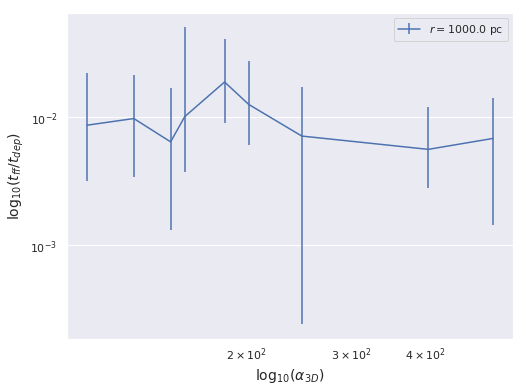

In [3]:
bins_plot("virial_parameter_3d", "SFR_efficiency", 10, r, numbers, colors, labels, names, 
          log_x=True, log_y=True, sigma_SFR_null=False, fields_null=False)

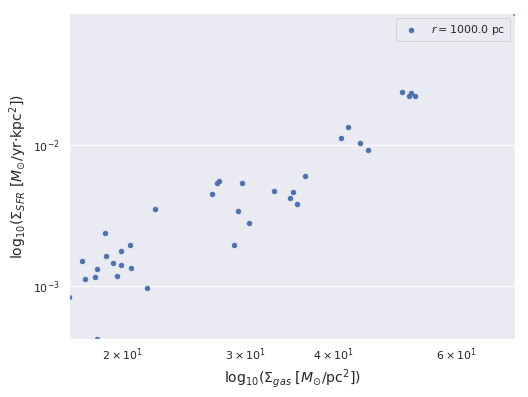

In [6]:
scatter_plot("sigma_gas", "sigma_SFR", r, numbers, colors, labels, names, 
             log_x=True, log_y=True, sigma_SFR_null=True, fields_null=True)